# Membership Inference Attack on shadow models

## Imports

In [1]:
# Generic libraries
import numpy as np
import pandas as pd
import pickle
import copy
import random
import os
import seaborn as sns

from os.path import join as osj
from torch import nn
from bisect import bisect
from collections import defaultdict 

# Paper Libraries for functions
from ecg_utilities import *
from ecg_utilities import get_performance_metrics

import logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Functions

In [2]:
# LOAD DATA
def load_train_test_data(m, e):
    with open(osj("..", "dp_models", "train_test_data", m, f"{e}_data.pkl"), "rb") as f:
        data = pickle.load(f)
    return data 

def load_real_train_test_data():
    with open(osj("..", "dp_models", "train_test_data", "real_data.pkl"), "rb") as f:
        data = pickle.load(f)
    return data

# LOAD PROBS
def load_dp_probs(model, mechanism, e):
    with open(osj("..", "dp_models", model, mechanism, f"{e}_probs.pkl"), "rb") as f:
        probs = pickle.load(f)
    return probs

def load_real_probs(model, mechanism):
    with open(osj("..", "dp_models", model, mechanism, "probs.pkl"), "rb") as f:
        probs = pickle.load(f)
    return probs

def save_attack_performance(attack, metrics):    
    with open(osj("..", "dp_models", "attacks", f"{attack}_performance.pkl"), "wb") as f:
        pickle.dump(metrics, f) 

def load_attack_performance(attack):    
    with open(osj("..", "dp_models", "attacks", f"{attack}_performance.pkl"), "rb") as f:
        metrics = pickle.load(f) 
    return metrics

## MIA on real data

In [3]:
# runs ~1 minute 

def train_real_mia():

    # define setup
    attack = "MIA" 
    models = ["DA_shadow", "Ens_val_shadow"]
    mechanism = "no_dp"

    # load data
    data  = load_real_train_test_data() # X

    model_metrics = {}

    for model in models:
        probs = load_real_probs(model, mechanism) # y

        test_dict = {}
        train_dict = {}
        mechanism_metrics = {}

        # extract data for attack model training
        for patient_id in data.keys():
            # label = 0 for data used for testing
            test_dict[patient_id] = {
                "probs": probs[patient_id]["test"],
                "labels": np.zeros(len(data[patient_id]["Test_x"]))
            }

            if model == "Ens_val_shadow":    
                # label = 1 for data used for training (train + val)
                train_dict[patient_id] = {
                    "probs": np.concatenate([probs[patient_id]["train"], probs[patient_id]["val"]]),
                    "labels": np.ones(len(data[patient_id]["Val_x"]))
                }
            else: 
                # label = 1 for data used for training
                train_dict[patient_id] = {
                    "probs": probs[patient_id]["train"],
                    "labels": np.ones(len(data[patient_id]["Val_x"]))
                }


        # Create flat dictionary for probs and labels only
        flat_dict = {"probs": [], "labels": []}

        for patient_id, values in test_dict.items():
            flat_dict["probs"].extend(values["probs"])
            flat_dict["labels"].extend(values["labels"])

        for patient_id, values in train_dict.items():
            flat_dict["probs"].extend(values["probs"])
            flat_dict["labels"].extend(values["labels"])

        X = flat_dict["probs"]
        y = flat_dict["labels"]

        # final data split for training the MIA model
        X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        X_attack_train = np.array(X_attack_train).reshape(-1, 1)
        X_attack_test  = np.array(X_attack_test).reshape(-1, 1)

        # Random Forest as MIA model
        attacker_model = RandomForestClassifier(n_estimators=100, random_state=42)
        attacker_model.fit(X_attack_train, y_attack_train)

        y_pred = attacker_model.predict(X_attack_test)

        acc = accuracy_score(y_attack_test, y_pred)
        pre, rec, f1, _ = precision_recall_fscore_support(y_attack_test, y_pred, average="binary")

        metrics = {"acc":acc, "rec":rec, "pre":pre, "f1":f1}
        mechanism_metrics[mechanism] = metrics
        model_metrics[model] = mechanism_metrics

    save_attack_performance(attack, model_metrics)


In [ ]:
train_real_mia()

In [ ]:
# model_metrics

# {'DA_shadow': {'no_dp': {'acc': 0.5808620007908264,
#    'rec': 0.7059352967648382,
#    'pre': 0.6412317754462461,
#    'f1': 0.672029702970297}},
#  'Ens_val_shadow': {'no_dp': {'acc': 0.585850290476625,
#    'rec': 0.7154857742887144,
#    'pre': 0.6435349673937486,
#    'f1': 0.677605720509542}}}

## MIA on DP data

In [ ]:
# attack_setup = pd.read_pickle("../files/attack_setup.pkl")
# attack_setup_val = attack_setup[attack_setup["Model"] == "Ens_val"] 
# attack_setup_val
# list(set(attack_setup_val["Method"].tolist()))

In [3]:
# runs 30 seconds per epsilon

# def train_dp_mia():

# define setup
attack = "MIA" 
models = ["DA_shadow", "Ens_val_shadow"]
p_method = ["laplace", "bounded_n", "gaussian_a", "laplace_truedp"]

# load epsilon values to be tested
attack_setup = pd.read_pickle("../files/attack_setup.pkl") # dataframe with columns: Model, Method, Epsilon

# model_metrics = {}
model_metrics = load_attack_performance(attack)

########  MODEL  ########
for model in models:

    # filter epsilon values for the current model
    current_model = "DA" if model == "DA_shadow" else "Ens_val"
    attack_setup_mod = attack_setup.copy()
    attack_setup_mod = attack_setup_mod[attack_setup_mod["Model"] == current_model] 

    ########  MECHANISM  ########
    for mechanism in p_method: #list(set(attack_setup_mod["Method"].tolist())): # requires deduplication

        epsilon_metrics = {}
        hp_epsilon_values = attack_setup_mod[attack_setup_mod["Method"] == mechanism]["Epsilon"].tolist()

        ########  EPSILON  ########
        for epsilon in hp_epsilon_values:

            try: 
                model_metrics[model][mechanism][epsilon]
                logger.info(f"Skipping existing epsilon {epsilon} for {mechanism} in {model}...")
                continue
            except KeyError:
                
                model_metrics[model][mechanism][epsilon] = None

                data  = load_train_test_data(mechanism, epsilon) # X
                probs = load_dp_probs(model, mechanism, epsilon) # y

                test_dict = {}
                train_dict = {}
                
                # extract data for attack model training
                for patient_id in data.keys():
                    # label = 0 for data used for testing
                    test_dict[patient_id] = {
                        "probs": probs[patient_id]["test"],
                        "labels": np.zeros(len(data[patient_id]["Test_x"]))
                    }

                    if model == "Ens_val_shadow":    
                        # label = 1 for data used for training (train + val)
                        train_dict[patient_id] = {
                            "probs": np.concatenate([probs[patient_id]["train"], probs[patient_id]["val"]]),
                            "labels": np.ones(len(data[patient_id]["Val_x"]))
                        }
                    else: 
                        # label = 1 for data used for training
                        train_dict[patient_id] = {
                            "probs": probs[patient_id]["train"],
                            "labels": np.ones(len(data[patient_id]["Val_x"]))
                        }

                # Create flat dictionary for probs and labels only
                flat_dict = {"probs": [], "labels": []}

                for patient_id, values in test_dict.items():
                    flat_dict["probs"].extend(values["probs"])
                    flat_dict["labels"].extend(values["labels"])

                for patient_id, values in train_dict.items():
                    flat_dict["probs"].extend(values["probs"])
                    flat_dict["labels"].extend(values["labels"])

                X = flat_dict["probs"]
                y = flat_dict["labels"]

                # final data split for training the MIA model
                X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

                X_attack_train = np.array(X_attack_train).reshape(-1, 1)
                X_attack_test  = np.array(X_attack_test).reshape(-1, 1)

                # Random Forest as MIA model
                logger.info(f"Training random forest MIA model for epsilon {epsilon}, {mechanism}, {model}...")
                attacker_model = RandomForestClassifier(n_estimators=100, random_state=42)
                attacker_model.fit(X_attack_train, y_attack_train)

                y_pred = attacker_model.predict(X_attack_test)

                acc = accuracy_score(y_attack_test, y_pred)
                pre, rec, f1, _ = precision_recall_fscore_support(y_attack_test, y_pred, average="binary")

                metrics = {"acc":acc, "rec":rec, "pre":pre, "f1":f1}

                model_metrics[model][mechanism][epsilon] = metrics
        
        save_attack_performance(attack, model_metrics)
        logger.info(f"Saved updated attack performance for {mechanism}.")

logger.info(f"Done !")

2025-05-14 13:00:56 - INFO - Training random forest MIA model for epsilon 5.91, laplace, DA_shadow...
2025-05-14 13:01:35 - INFO - Skipping existing epsilon 2.01 for laplace in DA_shadow...
2025-05-14 13:01:35 - INFO - Skipping existing epsilon 3.01 for laplace in DA_shadow...
2025-05-14 13:01:37 - INFO - Training random forest MIA model for epsilon 0.091, laplace, DA_shadow...
2025-05-14 13:02:10 - INFO - Training random forest MIA model for epsilon 0.021, laplace, DA_shadow...
2025-05-14 13:02:41 - INFO - Training random forest MIA model for epsilon 0.11, laplace, DA_shadow...
2025-05-14 13:03:11 - INFO - Saved updated attack performance for laplace.
2025-05-14 13:03:11 - INFO - Training random forest MIA model for epsilon 0.71, bounded_n, DA_shadow...
2025-05-14 13:03:40 - INFO - Training random forest MIA model for epsilon 1.21, bounded_n, DA_shadow...
2025-05-14 13:04:09 - INFO - Skipping existing epsilon 1.91 for bounded_n in DA_shadow...
2025-05-14 13:04:09 - INFO - Skipping exi

In [ ]:
# save_attack_performance(attack, model_metrics)

In [ ]:
# model_metrics

# MIA Performance Evaluation

In [4]:
mia_perf = load_attack_performance("MIA")

In [5]:
attack_setup = pd.read_pickle("../files/attack_setup.pkl")

In [6]:
mia_perf = load_attack_performance("MIA")
data = []

for model in mia_perf.keys():
    for mechanism in mia_perf[model].keys():
        if mechanism == "no_dp":
            for metric, value in mia_perf[model][mechanism].items():
                record = {"Model": model, "Method": mechanism, "Epsilon": None, "Metric": metric, "Value": value}
                data.append(record)
        else:
            for epsilon, metrics in mia_perf[model][mechanism].items():
                for metric, value in mia_perf[model][mechanism][epsilon].items():
                    record = {"Model": model, "Method": mechanism, "Epsilon": epsilon, "Metric": metric, "Value": value}
                    data.append(record)

df_mia_perf = pd.DataFrame(data, columns=["Model", "Method", "Epsilon", "Metric", "Value"])


In [7]:
df_mia_perf

,Model,Method,Epsilon,Metric,Value
0,DA_shadow,no_dp,NaN,acc,0.580862
1,DA_shadow,no_dp,NaN,rec,0.705935
2,DA_shadow,no_dp,NaN,pre,0.641232
3,DA_shadow,no_dp,NaN,f1,0.672030
4,DA_shadow,laplace,2.01,acc,0.580268
...,...,...,...,...,...
227,Ens_val_shadow,laplace_truedp,1.41,f1,0.689245
228,Ens_val_shadow,laplace_truedp,0.71,acc,0.587439
229,Ens_val_shadow,laplace_truedp,0.71,rec,0.733621
230,Ens_val_shadow,laplace_truedp,0.71,pre,0.644756


In [11]:
df_mia_perf["Model"].value_counts()

DA_shadow         76
Ens_val_shadow    72
Name: Model, dtype: int64

In [12]:
np.set_printoptions(suppress=True) 
df_mia_perf["Epsilon"].unique()

array([    nan, 2.01   , 3.01   , 1.91   , 0.81   , 5.01   , 9.91   ,
       0.71   , 9.01   , 9.51   , 0.91   , 1.41   , 0.01   , 0.021  ,
       0.00001, 0.0001 , 1.51   , 0.41   , 8.51   , 1.11   , 0.11   ,
       1.01   , 0.051  , 0.011  , 0.001  , 0.091  , 0.081  , 0.071  ])

In [13]:
df_mia_perf["Method"].value_counts()

laplace_truedp    60
bounded_n         32
gaussian_a        32
laplace           16
no_dp              8
Name: Method, dtype: int64

In [20]:
df_mia_perf[(df_mia_perf["Method"] == "no_dp")]

,Model,Method,Epsilon,Metric,Value
0,DA_shadow,no_dp,NaN,acc,0.580862
1,DA_shadow,no_dp,NaN,rec,0.705935
2,DA_shadow,no_dp,NaN,pre,0.641232
3,DA_shadow,no_dp,NaN,f1,0.672030
76,Ens_val_shadow,no_dp,NaN,acc,0.585850
77,Ens_val_shadow,no_dp,NaN,rec,0.715486
78,Ens_val_shadow,no_dp,NaN,pre,0.643535
79,Ens_val_shadow,no_dp,NaN,f1,0.677606


In [13]:
df_mia_f1 = df_mia_perf[df_mia_perf["Metric"] == "pre"]
df_mia_f1 = df_mia_f1[df_mia_f1["Epsilon"].notna()]

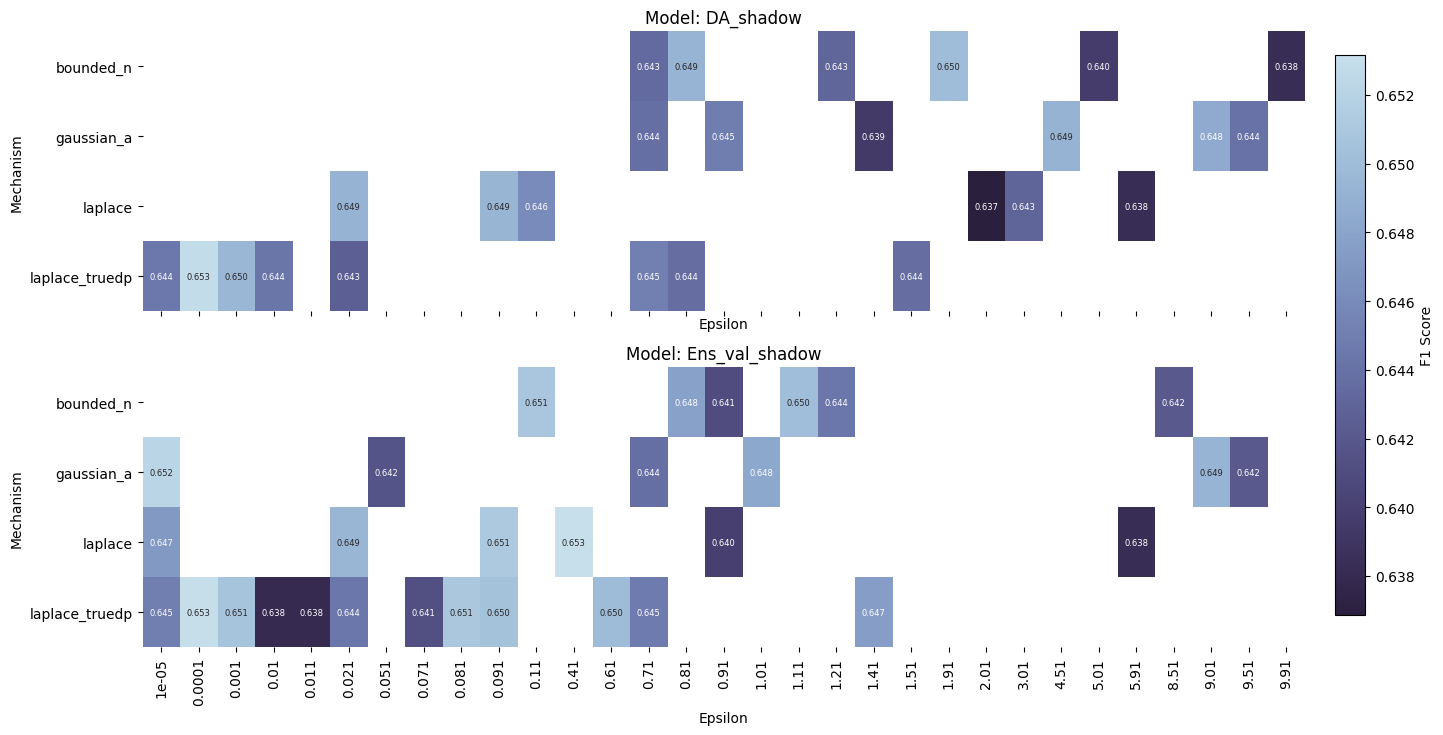

In [14]:
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

# Get unique models
models = df_mia_f1["Model"].unique()
epsilon_order = sorted(df_mia_f1["Epsilon"].unique())

# Setup figure with one subplot per model
fig, axes = plt.subplots(
    nrows=len(models), 
    ncols=1, 
    figsize=(15, 4 * len(models)), 
    sharex=True
    )

# Set common color scale range for all heatmaps
vmin = df_mia_f1["Value"].min()
vmax = df_mia_f1["Value"].max()
cmap = sns.color_palette("ch:s=.25,rot=-.25_r", as_cmap=True)


# Plot one heatmap per model
for i, model in enumerate(models):
    data = df_mia_f1[df_mia_f1["Model"] == model]
    heatmap_data = data.pivot(index="Method", columns="Epsilon", values="Value").reindex(columns=epsilon_order)

    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        fmt=".3f",
        cmap=cmap,
        cbar=False,
        vmin=vmin,
        vmax=vmax,
        annot_kws={"size": 6}
    )
    axes[i].set_title(f"Model: {model}")
    axes[i].set_ylabel("Mechanism")

    if i == len(models) - 1:
        axes[i].set_xlabel("Epsilon")

# Add single colorbar aligned to the full figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cbar_ax, label="F1 Score")

plt.subplots_adjust(right=0.9)
plt.show()

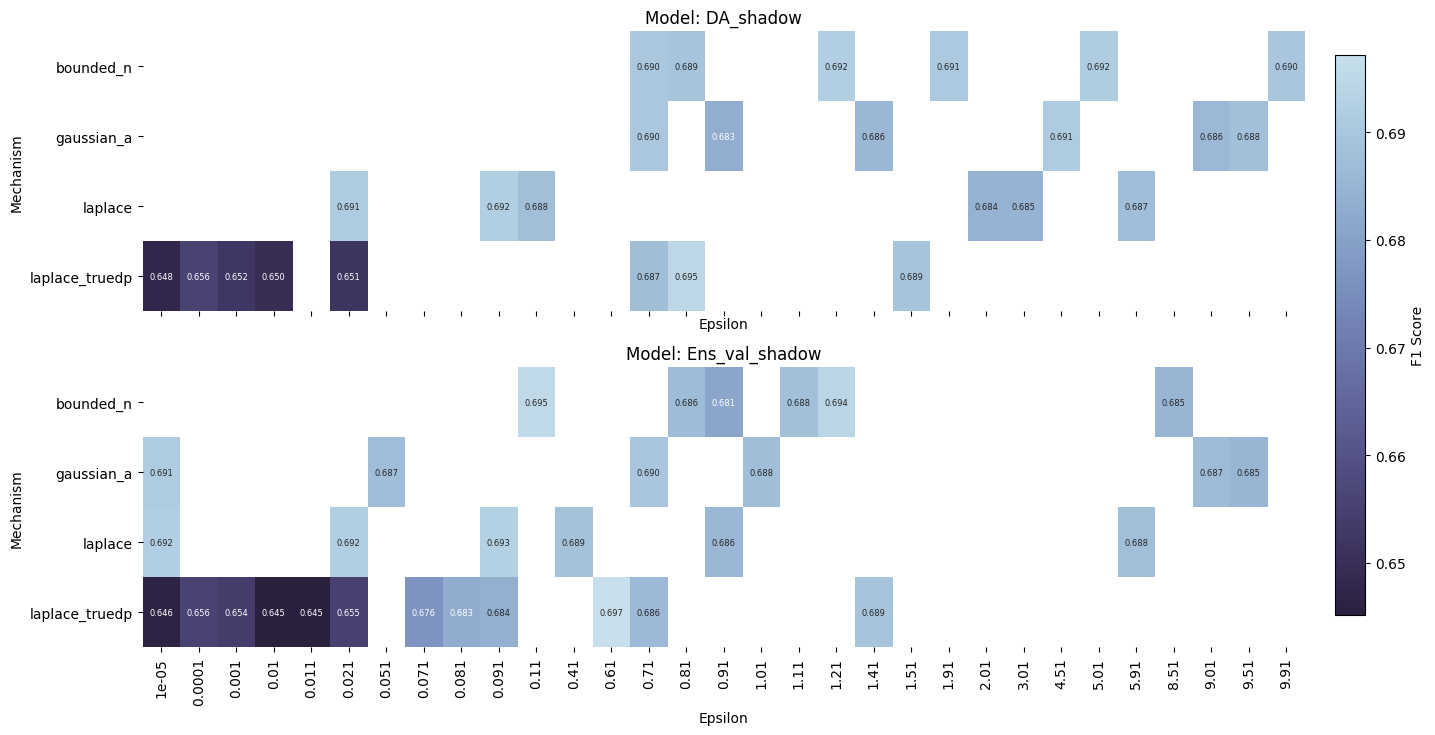

In [12]:
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

# Get unique models
models = df_mia_f1["Model"].unique()
epsilon_order = sorted(df_mia_f1["Epsilon"].unique())

# Setup figure with one subplot per model
fig, axes = plt.subplots(
    nrows=len(models), 
    ncols=1, 
    figsize=(15, 4 * len(models)), 
    sharex=True
    )

# Set common color scale range for all heatmaps
vmin = df_mia_f1["Value"].min()
vmax = df_mia_f1["Value"].max()
cmap = sns.color_palette("ch:s=.25,rot=-.25_r", as_cmap=True)


# Plot one heatmap per model
for i, model in enumerate(models):
    data = df_mia_f1[df_mia_f1["Model"] == model]
    heatmap_data = data.pivot(index="Method", columns="Epsilon", values="Value").reindex(columns=epsilon_order)

    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        fmt=".3f",
        cmap=cmap,
        cbar=False,
        vmin=vmin,
        vmax=vmax,
        annot_kws={"size": 6}
    )
    axes[i].set_title(f"Model: {model}")
    axes[i].set_ylabel("Mechanism")

    if i == len(models) - 1:
        axes[i].set_xlabel("Epsilon")

# Add single colorbar aligned to the full figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cbar_ax, label="F1 Score")

plt.subplots_adjust(right=0.9)
plt.show()


In [ ]:
# relevant_metrics = ["f1_score", "acc", "sens", "spec", "prec"]

# select_setups = df_mia_perf.set_index(["Method", "Epsilon"]).index.isin(attack_setup.set_index(["Method", "Epsilon"]).index)
# selected_results = df_mia_perf[select_setups]
# selected_results

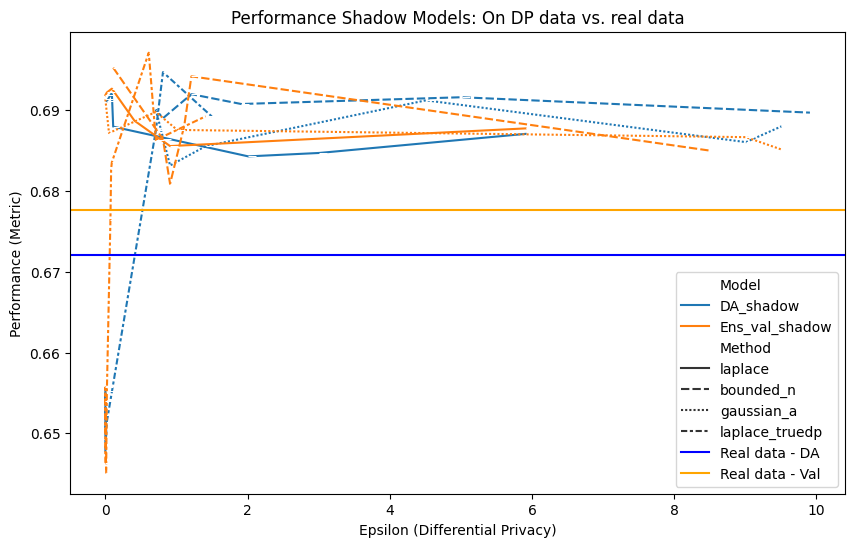

In [8]:
df_f1_mia     = df_mia_perf[(df_mia_perf["Metric"] == "f1")]
dp_perf_mia   = df_f1_mia[df_f1_mia["Epsilon"] >= 0]
real_perf_mia_da  = df_f1_mia[(df_f1_mia["Method"] == "no_dp") & (df_f1_mia["Model"] == "DA_shadow")]["Value"].values[0]
real_perf_mia_val = df_f1_mia[(df_f1_mia["Method"] == "no_dp") & (df_f1_mia["Model"] == "Ens_val_shadow")]["Value"].values[0]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dp_perf_mia,
    x="Epsilon", 
    y="Value", 
    hue="Model",
    style="Method", 
    marker=True
)

plt.axhline(y=real_perf_mia_da, linestyle="-", label=f"Real data - DA", color="blue")
plt.axhline(y=real_perf_mia_val, linestyle="-", label=f"Real data - Val", color="orange")
# plt.xscale("log") 
plt.xlabel("Epsilon (Differential Privacy)")
plt.ylabel("Performance (Metric)")
plt.title("Performance Shadow Models: On DP data vs. real data")
plt.legend()
plt.show()